In [1]:
%matplotlib inline

# Demo of Core workflow functionality 

This notebook will briefly cover how to run `assaydata`, `train`, `predict`, `design` workflows. 

For more information please [read the docs](https://docs.openprotein.ai/).

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import json
import pandas as pd
import seaborn as sns 
sns.set() 

from AWSTools.Batchtools.batch_utils import fakeseq # Used for creating fake protein sequences for testing


## Setup

Connect to the OpenProtein backend with your credentials:

In [3]:
import openprotein_python as openprotein

with open('../../../../secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(username= config['username'], password= config['password']) 

Load some demo data:

In [4]:
dataset = pd.read_csv("./data/core.csv")
dataset.head(2)

,sequence,isobutyramide_normalized_fitness,acetamide_normalized_fitness,propionamide_normalized_fitness
0,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,-0.5174,NaN,NaN
1,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,-0.5154,-2.1514,-1.1457


## Data Upload

Create the Demo data in the backend to be able to use it with our suite of tools:

In [5]:
# Create
assay = session.data.create(dataset, "Dataset Name", "Dataset description")
assay_id = assay.id
assay

AssayMetadata(assay_name='Dataset Name', assay_description='Dataset description', assay_id='4c0e52b6-92f6-44b1-903e-34470c1338bf', original_filename='assay_data', created_date=datetime.datetime(2023, 8, 4, 4, 9, 40, 976130), num_rows=15, num_entries=41, measurement_names=['isobutyramide_normalized_fitness', 'acetamide_normalized_fitness', 'propionamide_normalized_fitness'], sequence_length=346)

We could also have loaded a job from an old job ID. This will be faster and more efficient for users resuming workflows:

In [6]:
assay = session.data.load_job(assay_id) # can reload job to resume workflows

In [7]:
assay.get_first()

,sequence,isobutyramide_normalized_fitness,acetamide_normalized_fitness,propionamide_normalized_fitness
0,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,-0.5174,None,None


In [8]:
assay.get_slice(start=3, end=5)

,sequence,isobutyramide_normalized_fitness,acetamide_normalized_fitness,propionamide_normalized_fitness
0,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKWAEMIVGMK...,NaN,NaN,-0.7550
1,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKYAEMIVGMK...,-0.7448,-1.7992,-0.9711


In [9]:
assay.sequence_length

346

## Model training

We can use the assay object to create a training job:

In [10]:
train = session.train.create_training_job(assay,
                                          measurement_name=["isobutyramide_normalized_fitness", "acetamide_normalized_fitness"],
                                          model_name="mymodel") # name the resulting model
train_id = train.id
train

Jobplus(status=<JobStatus.PENDING: 'PENDING'>, job_id='32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16', job_type='/workflow/train', created_date=datetime.datetime(2023, 8, 4, 4, 9, 41, 265475), start_date=None, end_date=None, prerequisite_job_id='a5aad829-95d8-4b70-96fe-5d798219bcb5', progress_message=None, progress_counter=None, num_records=None, sequence_length=346)

In [11]:
#train = session.train.load_job(train_id)
#train

In [12]:
train.refresh()
train.status

<JobStatus.PENDING: 'PENDING'>

We can wait for the results before proceeding:

In [13]:
results = train.wait(verbose=False)

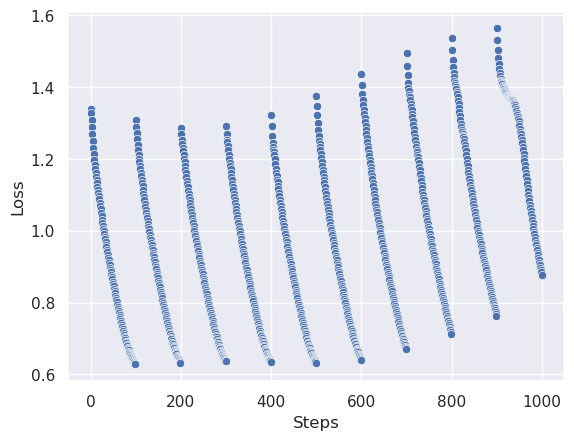

In [14]:
isobut_results = [i for i in results.traingraph if i.tag=="isobutyramide_normalized_fitness"]
sns.scatterplot(x=[i.step for i in isobut_results], y=[i.loss for i in isobut_results])
plt.xlabel("Steps")
plt.ylabel("Loss");

We can also request a cross-validation job to see the training results in more detail:

In [15]:
train.crossvalidate()
train.crossvalidation.id

'd86e8ede-2d10-4def-86bc-d84c87a83206'

In [16]:
cvdata = train.crossvalidation.wait()

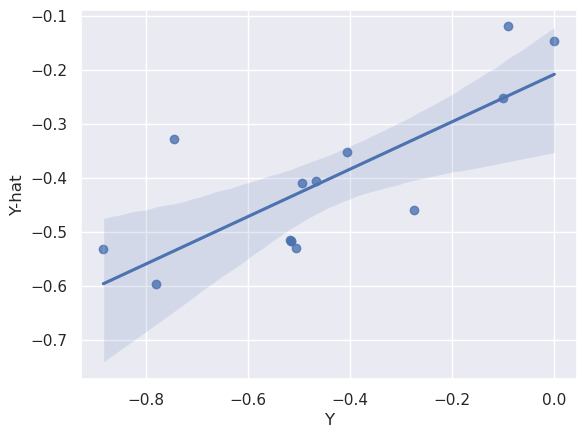

In [17]:
cvresult = [i for i in cvdata if i.measurement_name == "isobutyramide_normalized_fitness"]

sns.regplot(x=[i.y for i in cvresult], y=[i.y_mu for i in cvresult])
plt.xlabel("Y")
plt.ylabel("Y-hat");

We can examine the models associated with a train or assaydata set. These will be identical here but multiple train jobs are possible on a single assaydata:

In [18]:
train.list_models()

[{'name': 'mymodel - acetamide_normalized_fitness',
  'description': '',
  'model_id': 'b565e080-ddb5-418c-9f67-c0468990e57a',
  'training_assaydata': '4c0e52b6-92f6-44b1-903e-34470c1338bf',
  'job_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
  'created_date': '2023-08-04T04:11:22.933136',
  'model_type': 'EXACT_GP',
  'additional_metadata': {'input_dims': 13,
   'embedding_model': 'TorchLowRankSVD',
   'sequence_length': 346,
   'projection_layer': '4c0e52b6-92f6-44b1-903e-34470c1338bf_pca.joblib',
   'measurement_names': ['acetamide_normalized_fitness'],
   'original_task_index': 1}},
 {'name': 'mymodel - isobutyramide_normalized_fitness',
  'description': '',
  'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
  'training_assaydata': '4c0e52b6-92f6-44b1-903e-34470c1338bf',
  'job_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
  'created_date': '2023-08-04T04:11:22.395893',
  'model_type': 'EXACT_GP',
  'additional_metadata': {'input_dims': 13,
   'embedding_model': 'TorchLowRankSVD'

In [19]:
assay.list_models()

[{'name': 'mymodel - acetamide_normalized_fitness',
  'description': '',
  'model_id': 'b565e080-ddb5-418c-9f67-c0468990e57a',
  'training_assaydata': '4c0e52b6-92f6-44b1-903e-34470c1338bf',
  'job_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
  'created_date': '2023-08-04T04:11:22.933136',
  'model_type': 'EXACT_GP',
  'additional_metadata': {'input_dims': 13,
   'embedding_model': 'TorchLowRankSVD',
   'sequence_length': 346,
   'projection_layer': '4c0e52b6-92f6-44b1-903e-34470c1338bf_pca.joblib',
   'measurement_names': ['acetamide_normalized_fitness'],
   'original_task_index': 1}},
 {'name': 'mymodel - isobutyramide_normalized_fitness',
  'description': '',
  'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
  'training_assaydata': '4c0e52b6-92f6-44b1-903e-34470c1338bf',
  'job_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
  'created_date': '2023-08-04T04:11:22.395893',
  'model_type': 'EXACT_GP',
  'additional_metadata': {'input_dims': 13,
   'embedding_model': 'TorchLowRankSVD'

Let's take one of these models for further use:

In [20]:
model_id = train.list_models()[0]['model_id']
train.list_models()[0]

{'name': 'mymodel - acetamide_normalized_fitness',
 'description': '',
 'model_id': 'b565e080-ddb5-418c-9f67-c0468990e57a',
 'training_assaydata': '4c0e52b6-92f6-44b1-903e-34470c1338bf',
 'job_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
 'created_date': '2023-08-04T04:11:22.933136',
 'model_type': 'EXACT_GP',
 'additional_metadata': {'input_dims': 13,
  'embedding_model': 'TorchLowRankSVD',
  'sequence_length': 346,
  'projection_layer': '4c0e52b6-92f6-44b1-903e-34470c1338bf_pca.joblib',
  'measurement_names': ['acetamide_normalized_fitness'],
  'original_task_index': 1}}

## Sequence design

We can set up a design job using our trained model as a criteria:

In [22]:
from openprotein_python.models import DesignJobCreate, ModelCriterion, NMutationCriterion, Criterion
design_data = DesignJobCreate(
    assay_id=assay.id,
    criteria=[
        [
            ModelCriterion(
                criterion_type='model',
                model_id=model_id,
                measurement_name="acetamide_normalized_fitness",
                criterion=Criterion(target=-0.5, weight=1.0, direction="<")
            ),
        ],
        [NMutationCriterion(criterion_type="n_mutations", )]
    ],
    mutation_positions=[2,13],
    num_steps=10
)


json.loads(design_data.json())



{'assay_id': '4c0e52b6-92f6-44b1-903e-34470c1338bf',
 'criteria': [[{'criterion_type': 'model',
    'model_id': 'b565e080-ddb5-418c-9f67-c0468990e57a',
    'measurement_name': 'acetamide_normalized_fitness',
    'criterion': {'target': -0.5, 'weight': 1.0, 'direction': '<'}}],
  [{'criterion_type': 'n_mutations'}]],
 'num_steps': 10,
 'pop_size': None,
 'n_offsprings': None,
 'crossover_prob': None,
 'crossover_prob_pointwise': None,
 'mutation_average_mutations_per_seq': None,
 'mutation_positions': [2, 13]}

In [23]:
# create the design job
design_job = session.design.create_design_job(design_data)
design_id = design_job.id
design_job

Job(status=<JobStatus.PENDING: 'PENDING'>, job_id='7379c52b-a7b9-48b2-8d62-5583b2724a47', job_type='/workflow/design', created_date=datetime.datetime(2023, 8, 4, 4, 11, 48, 431695), start_date=None, end_date=None, prerequisite_job_id=None, progress_message=None, progress_counter=None, num_records=None)

In [24]:

#design_job = session.design.load_job(design_id)


In [25]:
results = design_job.wait()
results[-3:]

[DesignStep(step=9, sample_index=2557, sequence='MRHGDIMSSNMTVGVAVVFPKMPRDRSGEWRLDNADKIKYMTAGMKRKQQQYQLVVEPIRVWQGQMWDYAEYTEQMCYIPGCETSIHSDACKKVNVWGVYSLMGEKHEEHIDKAQYYTCDLIDMDGTFADKYYKISPWYQIEQWYWGQQDYVSRDPVDMKIYLAFCDCHNYPEIWYDTAMKGAYCCVPCNGSMQPAKDDEQQMAKAMQWCHNCYVEVKNMASGSGVQSDFRVSASIIFDQRIVAETGCTEMCIQYAQLSLSDQRYARCEPQSINKQFTIQMRGYSGLQASGDGDRPLIACPRHFVRTYVGTRVIYRESVHGNIRSTTGSAQADVGAWEYKMYENDA', initial_scores=[0, 195], scores=[[DesignSubscore(score=0, metadata=DesignMetadata(y_mu=-1.0524402856826782, y_var=0.008635343983769417))], [DesignSubscore(score=195, metadata=DesignMetadata(y_mu=None, y_var=None))]], umap1=9.221505165100098, umap2=5.6895341873168945),
 DesignStep(step=9, sample_index=2558, sequence='RRHGDISSNWDTYGVRVVNYTCPRLGHWAEVLANAPNCPGQILGMRLMLRGATGGRCPMYSLMGIMLTCAERMLTAQACVSETVHDFSEACRVATVWGVFKAGTQRCEECGIKGPYNCLVLIPQNGEAQQCYRKILLPCPMEGDYAQTQTYDSANPKGFESSQNHCRDPNEPSEWRDCASFGAELIVRCQGYRYPAKQIWPMNPKNMRWANNWYTGVANAACRDPHESIFPHSMIRGFDGRTWGYQGWEECITQCFQESLQQILSCRANDQSQNETFKIVKRSW

We can access the design results:

In [26]:
results[-1].scores

[[DesignSubscore(score=0, metadata=DesignMetadata(y_mu=-1.0229432582855225, y_var=0.008387535810470581))],
 [DesignSubscore(score=346, metadata=DesignMetadata(y_mu=None, y_var=None))]]

## Sequence predictions

We can also predict scores for new sequences using our models trained on our old sequences:

In [27]:
# Create some random sequences to predict
np.random.seed(111)
p_seqs = [fakeseq(assay.sequence_length) for i in range(3)]
p_seqs


['MVINYHGGMLRTPNHQMEMFQPEFYKCDGILVREQCWLKKWGGIPEFHARIMDCFQQQARMAGNKPIGYKHLYLLHMWCFEVIQAFTNQIAYGKQLPGDHPRTNWYHFEHTMNCNPQLHFTSGSLYRSTMEKLAYSCNYTYCVQTHMYYHRREVIEMLSPSNPARTARHHPHVDMELQIIINVENQVVIPTDWNPWWIRIMCIEPDRWDCMQKKDKVFSTHFRNINVCIRPEHRDDIFDEMYCKYPHRVECQHFSGWKGLPNINPHHRTFTTCGMDPPRMWCLRKVWIDTGKYPAFYSEAQGQFQCPKYEKDAYAKGFRTELGHEISSQYEVGNFTMTNQAIAGLA',
 'QRMNDISWFCLAEWYWYKKEWILMFLCDTDGDENQAKCQQINVQIIIYVPSRAVVEIMEALFVMSAHLYWYTAVADNFLLDSHLLDGRDNTTFMIIGTRQWSIVHRSGLSYYKQNDLSNKLQMQKRRLLMPEMWWIRNWPWLQLVLNMENARHTGYYHQSRNGVWQWIDLLEAQRGCHQRGYVNTRQALFFAADHQLWDHTIIYTVQWEPAHQKDDQVRKMICAEYDCIIVKSSAYCFCNFQFHQKEFGFKCFIVSHGALSLTYLHYVVFRPKEEPHWHGTISACKDDRPYGLWLMGTPPYFWAPSGKLANWNMMEPCETQDCFANNYPESWLKFWWVMTTGSKPS',
 'NSIMWHDIKCPRMMQWAWHVDNVATEVNTYNGDQTKGNGKFAHAQPSHFPYMFFWQMAIMGYHIDAAFPCLKNELVHGMCQWECLCIVNGRPVKPYENSVFSYHYDSEAKSYKFDKEEPMMFQFFELIQTATTHEYVWHECSSNQQNIGLNSQMNRHICQPEILIPLYRVTLLESGPMIVRHSAIKTYEPGPGWLPTGDFIKSFRQRTDMLIWTGFNRNVRVVGMMAFKTMHLGPAVCEFSQEDHHDHTLRWKHKWTKACKYWDIRQIANQLPCFSELEHKKTLIHCETQKDKFES

In [28]:
pjob = session.predict.create_predict_job(sequences=p_seqs, train_job=train)
pjob_id = pjob.id
pjob


Job(status=<JobStatus.PENDING: 'PENDING'>, job_id='d7fe72d9-1f5b-4889-ad66-2f4a9b619978', job_type='/workflow/predict', created_date=None, start_date=None, end_date=None, prerequisite_job_id=None, progress_message=None, progress_counter=0, num_records=None)

In [29]:
results = pjob.wait(verbose=True)

Waiting: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s, status=SUCCESS]


In [30]:
results[0].dict()

{'sequence': 'MVINYHGGMLRTPNHQMEMFQPEFYKCDGILVREQCWLKKWGGIPEFHARIMDCFQQQARMAGNKPIGYKHLYLLHMWCFEVIQAFTNQIAYGKQLPGDHPRTNWYHFEHTMNCNPQLHFTSGSLYRSTMEKLAYSCNYTYCVQTHMYYHRREVIEMLSPSNPARTARHHPHVDMELQIIINVENQVVIPTDWNPWWIRIMCIEPDRWDCMQKKDKVFSTHFRNINVCIRPEHRDDIFDEMYCKYPHRVECQHFSGWKGLPNINPHHRTFTTCGMDPPRMWCLRKVWIDTGKYPAFYSEAQGQFQCPKYEKDAYAKGFRTELGHEISSQYEVGNFTMTNQAIAGLA',
 'predictions': [{'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
   'model_name': 'mymodel - isobutyramide_normalized_fitness',
   'properties': {'isobutyramide_normalized_fitness': {'y_mu': -0.579990804195404,
     'y_var': 0.07199262827634811}}},
  {'model_id': 'b565e080-ddb5-418c-9f67-c0468990e57a',
   'model_name': 'mymodel - acetamide_normalized_fitness',
   'properties': {'acetamide_normalized_fitness': {'y_mu': -1.0524402856826782,
     'y_var': 0.008635327219963074}}}]}

We can also send a single sequence for single site mutation analysis:

In [31]:
sequence = assay.get_first().sequence[0]

sspredict = session.predict.create_predict_single_site(sequence, train)

In [32]:
ssp_results = sspredict.wait(verbose=True)
ssp_results[0:3]

Waiting: 100%|██████████| 100/100 [04:21<00:00,  2.62s/it, status=SUCCESS]


[SequencePrediction(position=0, amino_acid='A', predictions=[Prediction(model_id='32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16', model_name='mymodel - isobutyramide_normalized_fitness', properties={'isobutyramide_normalized_fitness': {'y_mu': -0.5117711424827576, 'y_var': 0.046446166932582855}}), Prediction(model_id='b565e080-ddb5-418c-9f67-c0468990e57a', model_name='mymodel - acetamide_normalized_fitness', properties={'acetamide_normalized_fitness': {'y_mu': -1.0585060119628906, 'y_var': 0.00857548974454403}})]),
 SequencePrediction(position=0, amino_acid='R', predictions=[Prediction(model_id='32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16', model_name='mymodel - isobutyramide_normalized_fitness', properties={'isobutyramide_normalized_fitness': {'y_mu': -0.3882597088813782, 'y_var': 0.018137391656637192}}), Prediction(model_id='b565e080-ddb5-418c-9f67-c0468990e57a', model_name='mymodel - acetamide_normalized_fitness', properties={'acetamide_normalized_fitness': {'y_mu': -1.0603432655334473, 'y_var': 0.

In [33]:
ssp_results[0:3][0].dict()

{'position': 0,
 'amino_acid': 'A',
 'predictions': [{'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16',
   'model_name': 'mymodel - isobutyramide_normalized_fitness',
   'properties': {'isobutyramide_normalized_fitness': {'y_mu': -0.5117711424827576,
     'y_var': 0.046446166932582855}}},
  {'model_id': 'b565e080-ddb5-418c-9f67-c0468990e57a',
   'model_name': 'mymodel - acetamide_normalized_fitness',
   'properties': {'acetamide_normalized_fitness': {'y_mu': -1.0585060119628906,
     'y_var': 0.00857548974454403}}}]}

In [36]:
preds = pd.DataFrame([i.dict() for i in ssp_results])
preds['acetamide_normalized_fitness'] = [i[1]['properties']['acetamide_normalized_fitness']['y_mu'] for i in preds.predictions]
preds.head()

,position,amino_acid,predictions,acetamide_normalized_fitness
0,0,A,[{'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9...,-1.058506
1,0,R,[{'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9...,-1.060343
2,0,N,[{'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9...,-1.060536
3,0,D,[{'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9...,-1.064618
4,0,C,[{'model_id': '32f2b480-f6d9-4d0c-9aeb-ec521d9...,-1.067208


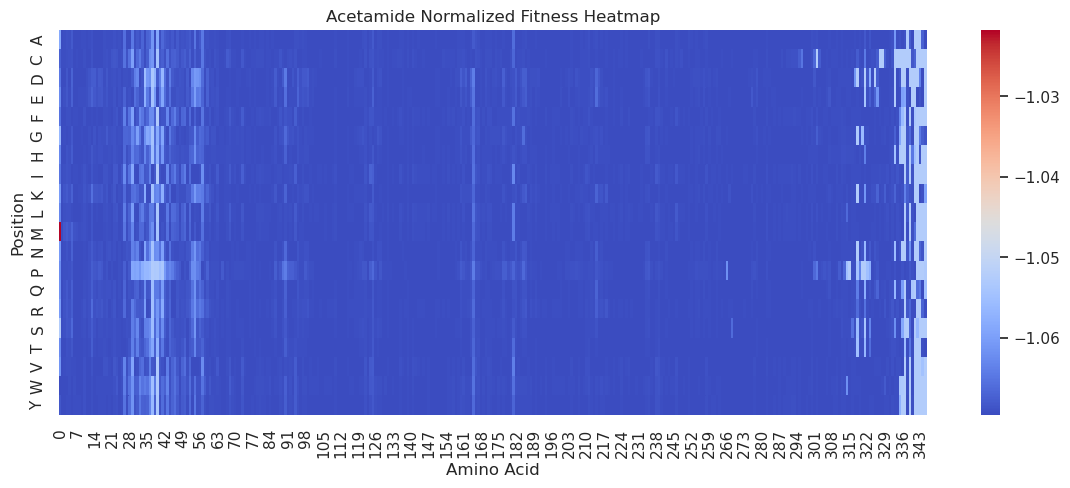

In [37]:

df_pivot = preds.pivot(columns='position', index='amino_acid', values='acetamide_normalized_fitness')

# Create  heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(df_pivot, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Acetamide Normalized Fitness Heatmap')
plt.xlabel('Amino Acid')
plt.ylabel('Position')
plt.show()


## Resume workflows 

Lastly, it's possible to resume from where you left off with the job id:

In [38]:
train = session.train.load_job(train_id)
train

Jobplus(status=<JobStatus.SUCCESS: 'SUCCESS'>, job_id='32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16', job_type='/workflow/train', created_date=datetime.datetime(2023, 8, 4, 4, 9, 41, 265475), start_date=datetime.datetime(2023, 8, 4, 4, 10, 50, 448570), end_date=datetime.datetime(2023, 8, 4, 4, 11, 23, 169511), prerequisite_job_id='a5aad829-95d8-4b70-96fe-5d798219bcb5', progress_message=None, progress_counter=None, num_records=None, sequence_length=346)

This reloaded job can be used as above for predict or design tasks, and those can also be reloaded!

In [39]:
pjob = session.predict.load_job(pjob_id)
pjob

Job(status=<JobStatus.SUCCESS: 'SUCCESS'>, job_id='d7fe72d9-1f5b-4889-ad66-2f4a9b619978', job_type='/workflow/predict', created_date=datetime.datetime(2023, 8, 4, 4, 24, 47, 600909), start_date=datetime.datetime(2023, 8, 4, 4, 24, 53, 718138), end_date=datetime.datetime(2023, 8, 4, 4, 25, 19, 662641), prerequisite_job_id='32f2b480-f6d9-4d0c-9aeb-ec521d9a7c16', progress_message=None, progress_counter=None, num_records=None)